In [1]:
import os
os.environ["JAX_ENABLE_X64"] = "True"
# os.environ["JAX_DISABLE_JIT"] = "True"
# os.environ["JAX_PLATFORM_NAME"] = "cpu"


import jax
import jax.numpy as jnp
import jax.random as jrandom
from jax.experimental import sparse
import jax.lax
import equinox as eqx
import scipy 
import numpy as np
import matplotlib.pyplot as plt

# Data

U_train shape: (3, 8000)


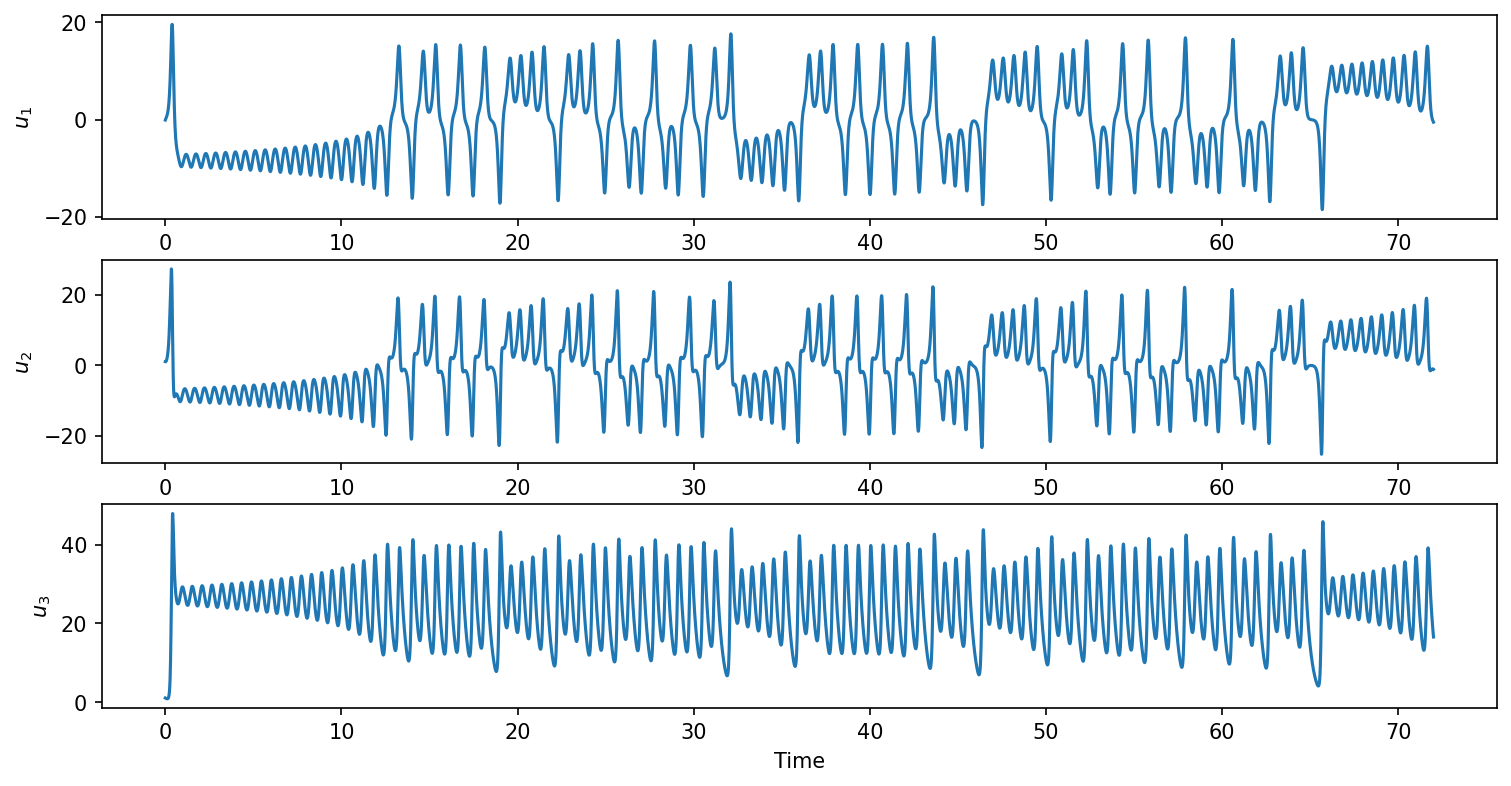

In [2]:
### Integrate + Plot Lorenz63 System

#xdot = f(x) definition
def lorenz(t,x):
    beta, rho, sigma = 8/3, 28, 10
    x1, x2, x3 = x
    dx1dt = sigma*(x2 - x1)
    dx2dt = x1*(rho - x3) - x2
    dx3dt = x1*x2 - beta*x3
    return np.array([dx1dt, dx2dt, dx3dt])

# integrate 
tN = 100
dt = 0.01
sol = scipy.integrate.solve_ivp(lorenz, t_span=(0,tN), y0=[-0.1, 1, 1.05], dense_output=True, rtol = 1e-12, atol = 1e-12, method = 'RK45')
t = np.arange(0,tN,dt)
U = sol.sol(t) # of shape (3, tN/dt)

# train-test split
test_perc = 0.2
lyap = 0.9
split_idx = int((1-test_perc) * U.shape[1])
U_train = U[:, :split_idx]
t_train = t[:split_idx] * lyap
U_test = U[:, split_idx:] 
t_test = t[split_idx:] * lyap
U_train = jnp.array(U_train)

print("U_train shape:", U_train.shape)

# plot training data
fig, ax = plt.subplots(3,1, figsize=(12, 6), dpi = 150)
for i in range(3):
    ax[i].plot(t_train, U_train[i])
    ax[i].set_ylabel(r'$u_{}$'.format(i+1))
ax[i].set_xlabel('Time')
plt.show()

# Jax RC Definition


In [ ]:
import jax.experimental


class ReservoirComputerJax(eqx.Module):
    Nr: int
    N_in: int
    N_out: int 
    alpha: float 
    beta: float 
    bias: float 
    W_in_sigma: float
    spinup: int

    Wr: jax.Array
    W_in: jax.Array
    W_out: jax.Array

    def __init__(self, 
                 N_out,
                 Nr, 
                 N_in = None, 
                 alpha = 0.6, 
                 beta = 1e-8,
                 bias = 1.6,
                 W_in_sigma = 0.084,
                 spinup = 0,

                 seed = 0,
                 Wr_density=0.02,
                 Wr_eig_max = 0.8,
                 ):
        
        # init RC parameters
        self.Nr = Nr
        self.N_out = N_out
        N_in = N_in if N_in else N_out # set N_in = N_out if N_in is not provided 
        self.N_in = N_in
        self.alpha = alpha
        self.beta = beta
        self.bias = bias
        self.W_in_sigma = W_in_sigma
        self.spinup = spinup

        # init Wr
        key = jrandom.PRNGKey(seed)
        Wr_key, W_in_key = jrandom.split(key)
        num_filled = int(Nr**2 * Wr_density)
        Wr_vals = jax.random.normal(Wr_key, shape=(num_filled))
        Wr_zeros = jnp.zeros((Nr**2 - num_filled)) 
        Wr_vec = jnp.concatenate([Wr_vals, Wr_zeros], axis=0) # create vector filled with num_filled values and rest zeros
        Wr_idxs = jax.random.permutation(Wr_key, jnp.arange(Nr**2)) # shuffle the vector
        self.Wr = Wr_vec[Wr_idxs].reshape((Nr,Nr))
        eigvals = jnp.linalg.eigvals(self.Wr)
        self.Wr = self.Wr * (Wr_eig_max / jnp.max(jnp.abs(eigvals))) # rescale the spectral radius of Wr
        self.Wr = sparse.BCOO.fromdense(self.Wr) # make sparse

        # init W_in 
        self.W_in = jrandom.uniform(W_in_key, shape=(Nr, N_in), minval=-W_in_sigma, maxval=W_in_sigma)    

        # init W_out (to be updated later) (figure out how to update)
        self.W_out = None

    def _update_state(self, r, u):
        r_next = jnp.tanh(self.Wr @ r + self.W_in @ u + self.bias)
        r_next = (1-self.alpha)*r + self.alpha * r_next 
        return r_next
    
    def train(self, U):

        # drive RC and collect reservoir states
        def drive_RC_train(r, u):
            r_next = self._update_state(r,u)
            return r_next, r_next
        r0 = jnp.zeros((self.Nr,))
        _, R = jax.lax.scan(drive_RC_train, r0, U.T)
        R = R.T # stick with convention of Nr x Nt

        # discard spinup
        U = U[:, self.spinup:]
        R = R[:, self.spinup:]

        # Align R with next state of U 
        R = R[:, :-1] 
        U = U[:, 1:] 

        # Solve ridge regression: min ||AX - B||^2 + beta||X||^2
        A = R @ R.T + self.beta * jnp.eye(self.Nr)
        B = R @ U.T
        W_out = jax.scipy.linalg.solve(A,B, assume_a="sym").T

        return W_out, R
    
    def forecast(self, n, W_out, r0):
        # drive autonoumous RC and collect reservoir states
        def drive_RC_test(r, _):
            u_pred = W_out @ r
            r_next = self._update_state(r, u_pred)
            return r_next, u_pred
        _, U_pred = jax.lax.scan(drive_RC_test, r0, length = n)

        return U_pred.T


In [4]:
# init, train, forecast
NR = 200
RC = ReservoirComputerJax(N_out = 3, Nr = NR)
W_out, R = RC.train(U_train)
r0 = R[:, -1]
n = U_test.shape[1]
U_pred = RC.forecast(n, W_out, r0)

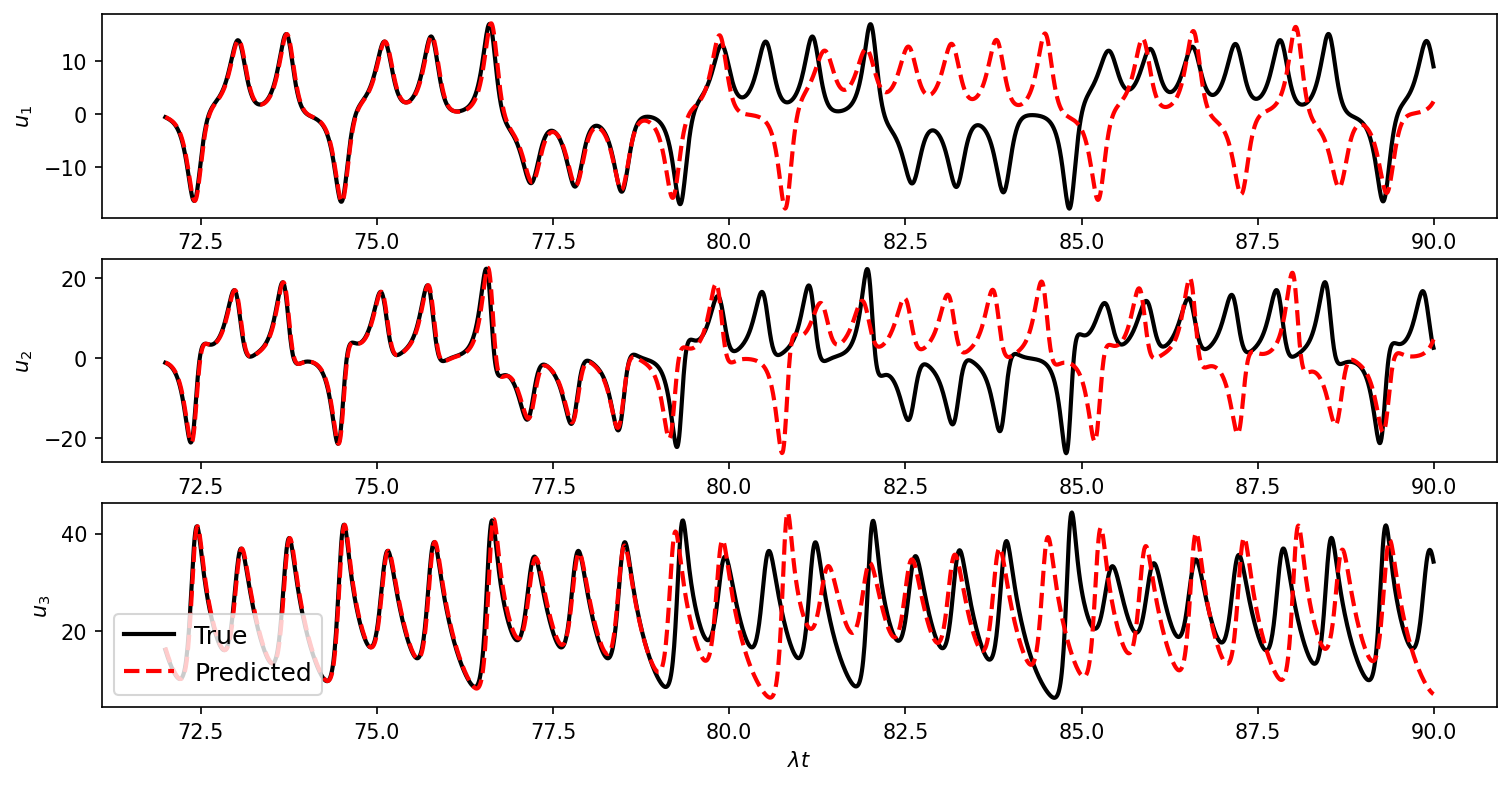

In [5]:
# plot forecast
lw = 2
fig, ax = plt.subplots(3,1, figsize=(12, 6), dpi = 150)
for i in range(3):
    ax[i].plot(t_test, U_test[i], label='True', color = 'k', linewidth = lw)
    ax[i].plot(t_test, U_pred[i], 'r--', label='Predicted', linewidth = lw)
    ax[i].set_ylabel(r'$u_{}$'.format(i+1))
ax[i].set_xlabel(r'$\lambda t$')
plt.legend(loc = 'lower left', fontsize = 12)
plt.show()

# Time predictions

In [6]:
# single prediction
def RC_init_train_fore(U_train,n_test,seed):
    RC = ReservoirComputerJax(N_out = 3, Nr = 200, seed = seed)
    W_out, R = RC.train(U_train)
    r0 = R[:, -1]
    U_pred = RC.forecast(n_test, W_out, r0)

n_test = U_test.shape[1]
%timeit RC_init_train_fore(U_train=U_train, n_test=n_test, seed = 0)

857 ms ± 141 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
# multiple preds
ensemble_RC = jax.vmap(RC_init_train_fore, in_axes=[None, None, 0])
n = 3 
seeds = jnp.arange(n)
ensemble_RC(U_train, n_test, seeds)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape int64[]

The error arose for the nse argument of bcoo_fromdense. In order for
BCOO.fromdense() to be used in traced/compiled code, you must pass a concrete
value to the nse (number of stored elements) argument.

This BatchTracer with object id 129963569688032 was created on line:
  /tmp/ipykernel_2779494/2660568422.py:55 (__init__)

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [ ]:
# time a sweep
ns = [2, 4, 8, 16, 32, 64, 128]
time_avgs = []
time_stds = []
for n in ns:
    seeds = jnp.arange(n)
    res = %timeit -o ensemble_RC(U_train, n_test, seeds)
    time_avgs.append(res.average)
    time_stds.append(res.stdev)

430 ms ± 18.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
509 ms ± 14.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
631 ms ± 23.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
889 ms ± 20.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.48 s ± 29.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.64 s ± 18.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.99 s ± 55.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


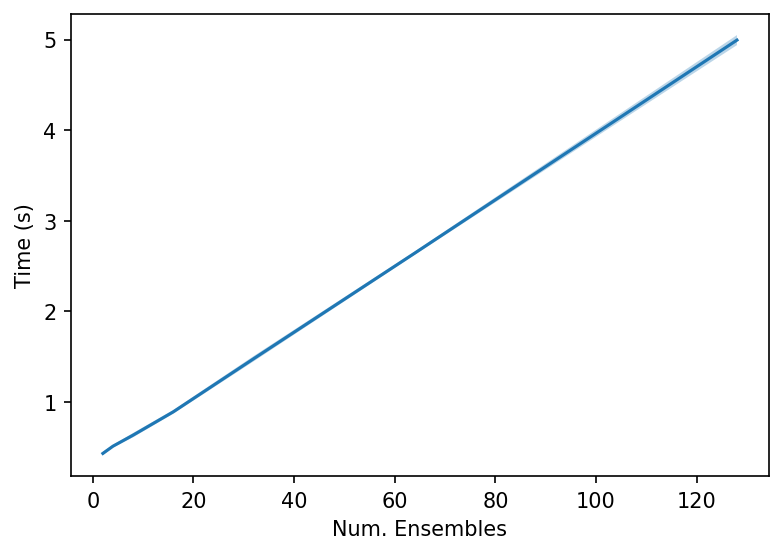

In [ ]:
time_avgs = jnp.array(time_avgs)
time_stds = jnp.array(time_stds)
plt.figure(figsize=(6,4), dpi = 150)
plt.plot(ns, time_avgs)
plt.fill_between(ns, time_avgs - time_stds,time_avgs + time_stds, alpha = 0.3)
plt.xlabel("Num. Ensembles")
plt.ylabel("Time (s)")
plt.show()

In [ ]:
# time_avgs_gpu = time_avgs
# time_stds_gpu = time_stds
# jax.config.update('jax_platform_name', 'cpu')

In [ ]:
# # time a sweep
# time_avgs = []
# time_stds = []
# for n in ns:
#     seeds = jnp.arange(n)
#     res = %timeit -o ensemble_RC(U_train, n_test, seeds)
#     time_avgs.append(res.average)
#     time_stds.append(res.stdev)

431 ms ± 18.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
539 ms ± 17.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
626 ms ± 18.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
894 ms ± 17.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.47 s ± 18.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.66 s ± 37.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.02 s ± 29.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


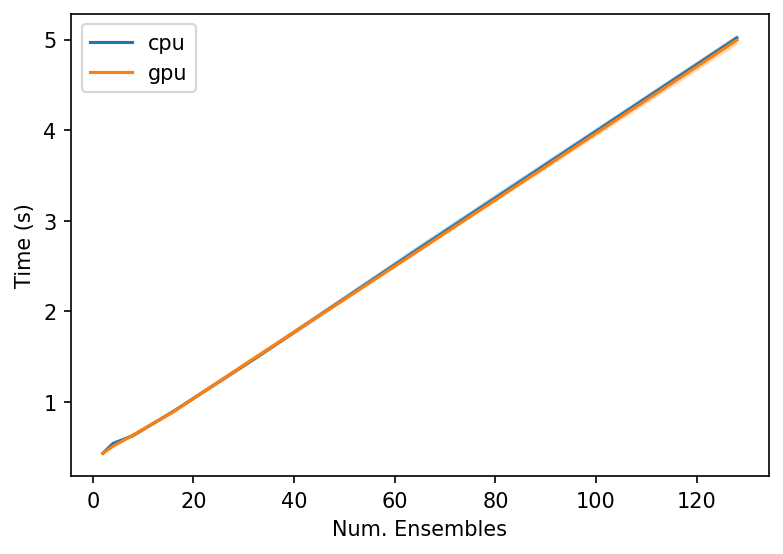

In [ ]:
# time_avgs = jnp.array(time_avgs)
# time_stds = jnp.array(time_stds)
# plt.figure(figsize=(6,4), dpi = 150)
# plt.plot(ns, time_avgs, label = "cpu")
# plt.fill_between(ns, time_avgs - time_stds,time_avgs + time_stds, alpha = 0.3)
# plt.plot(ns, time_avgs_gpu, label = "gpu")
# plt.fill_between(ns, time_avgs_gpu - time_stds_gpu,time_avgs_gpu + time_stds_gpu, alpha = 0.3)
# plt.xlabel("Num. Ensembles")
# plt.ylabel("Time (s)")
# plt.legend()
# plt.show()